# **Table of Contents**

* [Abstract](#section1)
* [Exploratory Data Analysis (EDA)](#section2)
    * [Meta Information Analysis](#section2a)
    * [Average Daily Views per Day](#section2b)
    * [Average Daily Views per Day (by Locale)](#section2c)
    * [Average Daily Views Distributions](#section2d)
    * [Average Daily Views Distributions (by Locale)](#section2e)
    * [Outlier Pages](#section2f)
* [Modeling](#section3)
    * [ARIMA](#section3a)
    * [ARIMA Forecasts](#section3b)
    * [Prophet](#section3c)
    * [Prophet Forecasts](#section3d)

<a id="section1"></a>
# Abstract

The goal of this project was to build a model that will forecast future web traffic for Wikipedia articles. The data consist of time series' for 145,000 articles, in different languages and accessed on various devices, between 2015-07-01 and 2016-12-31. After an exploratory analysis was conducted, ARIMA models were constructed to forecast the future web traffic of 4 articles 2 months into the future with 95% accuracy. Facebook's Prophet GAM model was also explored as an alternative to the ARIMA model. The findings in this project can be used to monitor the growth of Wikipedia's popularity and identify trending topics in order to create new pages that will garner additional views. Further analysis could be done by increasing the amount of data used in the Prophet model to obtain better results as well as investigating local trends on an hourly and daily basis. The data used in this project can be found on [Kaggle](https://www.kaggle.com/c/web-traffic-time-series-forecasting/data).

<a id="section2"></a>
# Exploratory Data Analysis (EDA)

In [222]:
# Importing the necessary libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings
import math
import itertools
from sklearn.metrics import mean_squared_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet

plt.style.use('fivethirtyeight')
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
# Functions

def plot_series(df, name, project, access, agent):
    
    '''
    Plot time series based on page meta info
    '''
    
    temp_df = df[(df['name'] == name) &
                 (df['project'] == project) &
                 (df['access'] == access) &
                 (df['agent'] == agent)]
    
    temp_df.set_index('locale', inplace=True)
    locales = temp_df.index
    temp_df = pd.DataFrame(temp_df.iloc[:,1:551])
    num_locales = len(temp_df)
    temp_df = temp_df.transpose()
    
    plt.figure(figsize=(16,8))
    plt.subplots_adjust(top=0.95);
    plt.rcParams.update({'font.size': 12});
        
    for i in range(num_locales):
        temp_df.iloc[:,i].plot()
        
    plt.legend(locales)  
    plt.xlabel("Date");
    plt.ylabel("Daily Views");
    plt.title(f"{name} Time Series"); 


def freq_plot(values, title=None, x_label=None, y_label=None, bins=100):
    '''
    Get a frequency plot, for a specific column, in a 
    dataframe.
    '''
        
    plt.rcParams.update({'font.size': 16})

    plt.figure(figsize=(16,8))
    plt.hist(values, bins = bins)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.show()
    
    
def train_test_split(series):
    '''
    Creates a train - test split
    '''
    train, test = series[:490], series[490:550]
    return train, test


def arima_fit(series):
    '''
    Fit an ARIMA model on a time series and then make predictions.
    Finds the best p,d,q parameter values and returns the best fit.
    '''
    best_pdq = ((0,0,0), 9999)
    p = d = q = range(5)
    pdq_list = list(itertools.product(p,d,q))
    
    for pdq in pdq_list:
        
        try:
            model = ARIMA(series.values, order=pdq)
            model_fit = model.fit()
            if model_fit.aic < best_pdq[1]:
                best_pdq = (pdq, model_fit.aic)
                
        except Exception:
            continue
            
    print(f"The best model fit that was found: {best_pdq}")
    
    model = ARIMA(series.values, order=best_pdq[0])
    model_fit = model.fit()
            
    return model_fit


def list_of_lists(df):
    '''
    Create a list of index values for each locale from a dataframe
    '''
    locales = ['fr', 'de', 'es', 'ja', 'en', 'ru', 'zh']
    return [df[df.index==locale] for locale in locales]


def prophet_model(series):
    '''
    Fit a model using Facebook Prophet.
    '''
    series = series.reset_index()
    series.columns = ['ds', 'y']
    
    fbp = Prophet()
    fbp.fit(series);
    
    future = fbp.make_future_dataframe(periods=60)
    
    forecast = fbp.predict(future)[['ds','yhat','yhat_lower', 'yhat_upper']].set_index('ds')
    
    return fbp, forecast

In [3]:
# Reading in the data

train_df = pd.read_csv('data/train_1.csv')
key_df = pd.read_csv('data/key_1.csv')

In [4]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
train_df.shape

(145063, 551)

In [6]:
key_df.head()

,Page,Id
0,!vote_en.wikipedia.org_all-access_all-agents_2...,bf4edcf969af
1,!vote_en.wikipedia.org_all-access_all-agents_2...,929ed2bf52b9
2,!vote_en.wikipedia.org_all-access_all-agents_2...,ff29d0f51d5c
3,!vote_en.wikipedia.org_all-access_all-agents_2...,e98873359be6
4,!vote_en.wikipedia.org_all-access_all-agents_2...,fa012434263a


In [7]:
key_df.shape

(8703780, 2)

In [8]:
# Expanding the Page column in train_df

train_df[['name', 'project', 'access', 'agent']] = train_df['Page'].str.rsplit('_', 3, expand=True)
train_df[['locale', 'project']] = train_df['project'].str.split('.', 1, expand=True)

In [9]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,name,project,access,agent,locale
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,20.0,22.0,19.0,18.0,20.0,2NE1,wikipedia.org,all-access,spider,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,30.0,52.0,45.0,26.0,20.0,2PM,wikipedia.org,all-access,spider,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,6.0,3.0,4.0,17.0,3C,wikipedia.org,all-access,spider,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,11.0,17.0,19.0,10.0,11.0,4minute,wikipedia.org,all-access,spider,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,wikipedia.org,all-access,spider,zh


<a id="section2a"></a>
## Meta Information Analysis

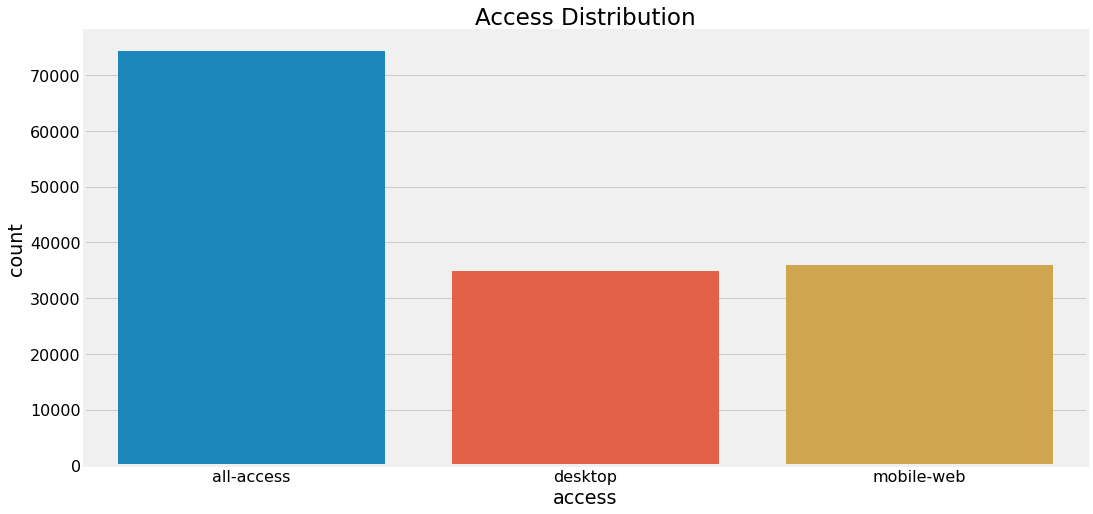

In [11]:
plt.figure(figsize=(16,8));
plt.rcParams.update({'font.size': 16});
sns.countplot(train_df['access']);
plt.title('Access Distribution');

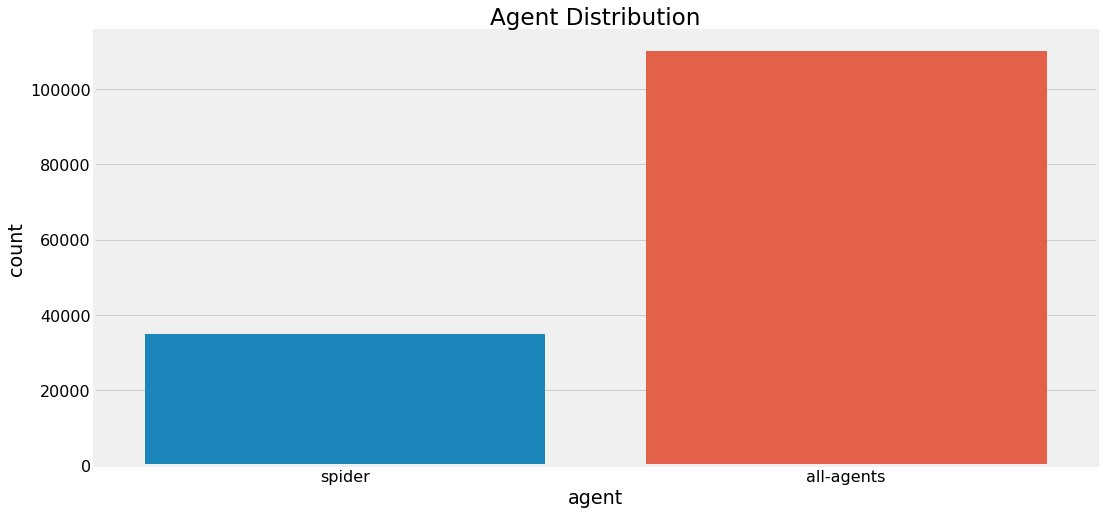

In [12]:
plt.figure(figsize=(16,8));
plt.rcParams.update({'font.size': 16});
sns.countplot(train_df['agent']);
plt.title('Agent Distribution');

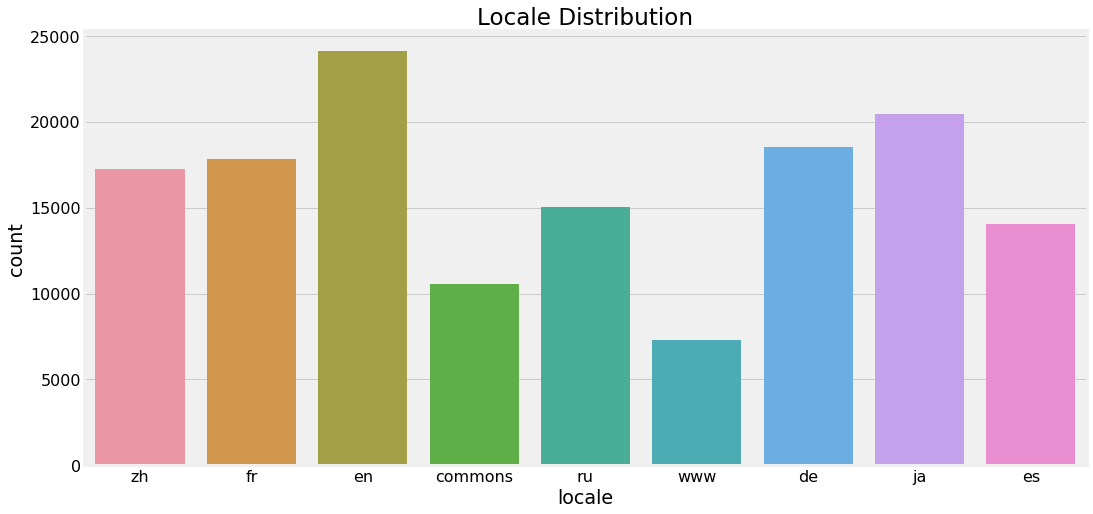

In [13]:
plt.figure(figsize=(16,8));
plt.rcParams.update({'font.size': 16});
sns.countplot(train_df['locale']);
plt.title('Locale Distribution');

We see that our Wikipedia data includes 7 languages: German, English, Spanish, French, Japanese, Russian, and Chinese. All-agents appear more frequently than Spider, and mobile visits are slightly more frequent than those from desktops.

<a id="section2b"></a>
## Average Daily Views per Day

Let's now take a look at the average views for each day across all articles. We'll first need to fill in null values. This will be done by propagating values forwards and backwards. Also, to make the analysis easier, a sample of 100,000 rows will be used from the data.

In [14]:
train_df = train_df.ffill().bfill()

In [15]:
train_df.head()

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31,name,project,access,agent,locale
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,20.0,22.0,19.0,18.0,20.0,2NE1,wikipedia.org,all-access,spider,zh
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,30.0,52.0,45.0,26.0,20.0,2PM,wikipedia.org,all-access,spider,zh
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,4.0,6.0,3.0,4.0,17.0,3C,wikipedia.org,all-access,spider,zh
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,11.0,17.0,19.0,10.0,11.0,4minute,wikipedia.org,all-access,spider,zh
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,11.0,27.0,13.0,36.0,10.0,52_Hz_I_Love_You,wikipedia.org,all-access,spider,zh


In [16]:
# Getting a random sample of 100,000 rows

random.seed(101)
train_trunc = train_df.loc[random.sample(list(train_df.index), 100000)].reset_index(drop = True)

In [17]:
means = train_trunc.iloc[:,1:551].mean(axis=0)
medians = train_trunc.iloc[:,1:551].median(axis=0)
maxes = train_trunc.iloc[:,1:551].max(axis=0)

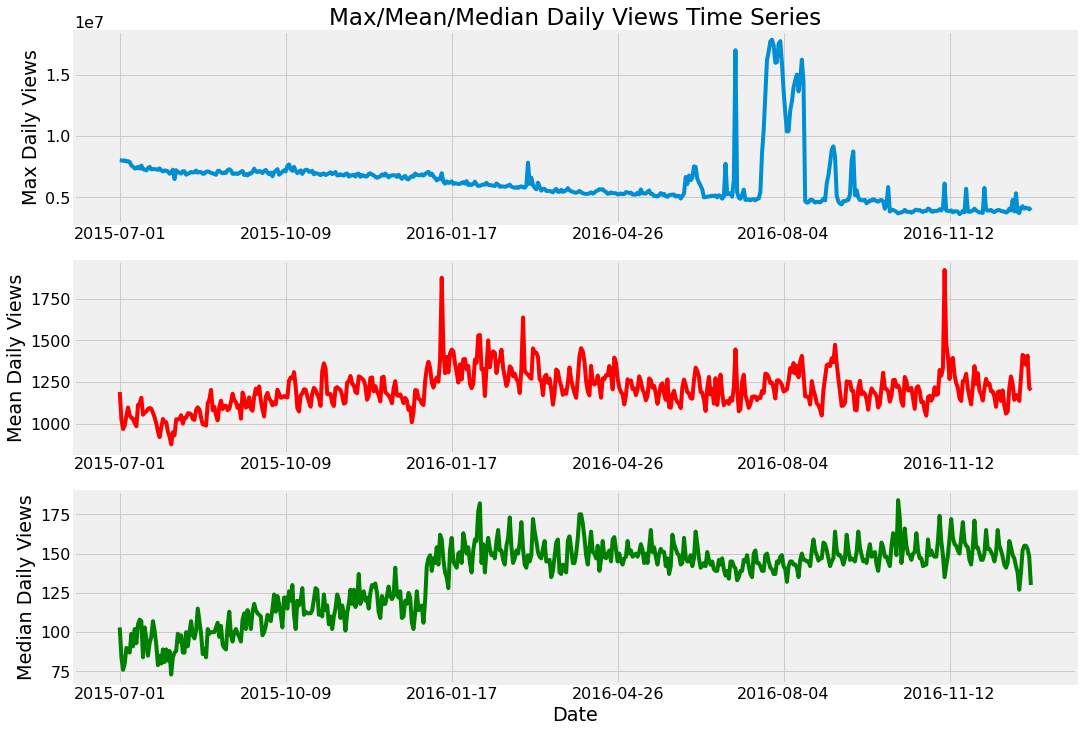

In [18]:
fig, ax = plt.subplots(3,1,figsize=(16,12));

plt.subplot(3,1,1);
maxes.plot();
plt.ylabel('Max Daily Views');
plt.title('Max/Mean/Median Daily Views Time Series');

plt.subplot(3,1,2);
means.plot(color = 'red');
plt.ylabel('Mean Daily Views');

plt.subplot(3,1,3);
medians.plot(color = 'green');
plt.xlabel('Date');
plt.ylabel('Median Daily Views');

We see that the max daily views across all articles has a negative trend since 2015 with huge outliers spikes in August of 2016. Mean and median daily views, on the other hand, trend upwards over time with a noticeable increase in the beginning of 2016. Notable peaks in the mean on 2016-01 and 2016-11. On these dates, it is likely that an event occurred causing the huge surges over to the website.

<a id="section2c"></a>
## Average Daily Views per Day (by Locale)

In [510]:
mean_locale = train_trunc.iloc[:,np.r_[1:551, -1]].groupby('locale',axis=0).mean().reset_index().set_index('locale').transpose().apply(np.log)
median_locale = train_trunc.iloc[:,np.r_[1:551, -1]].groupby('locale',axis=0).median().reset_index().set_index('locale').transpose().apply(np.log)
max_locale = train_trunc.iloc[:,np.r_[1:551, -1]].groupby('locale',axis=0).max().reset_index().set_index('locale').transpose().apply(np.log)


In [20]:
# Smoothing out the time series by calculating a 30-day rolling average for ease of analysis

locales = ['de', 'en', 'es', 'fr', 'ja', 'ru', 'zh']
mean_locale = mean_locale.rolling(30).mean().dropna()[locales]
median_locale = median_locale.rolling(30).mean().dropna()[locales]
max_locale = max_locale.rolling(30).mean().dropna()[locales]

In [41]:
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:pink','tab:cyan']

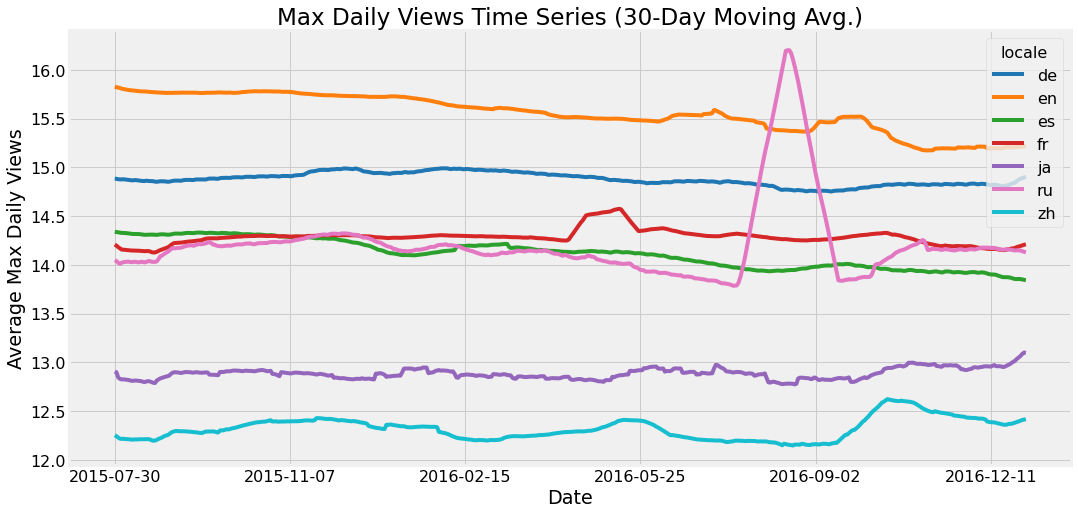

In [42]:
max_locale.plot(figsize=(16,8), color=colors);
plt.xlabel('Date');
plt.ylabel('Average Max Daily Views');
plt.title('Max Daily Views Time Series (30-Day Moving Avg.)');

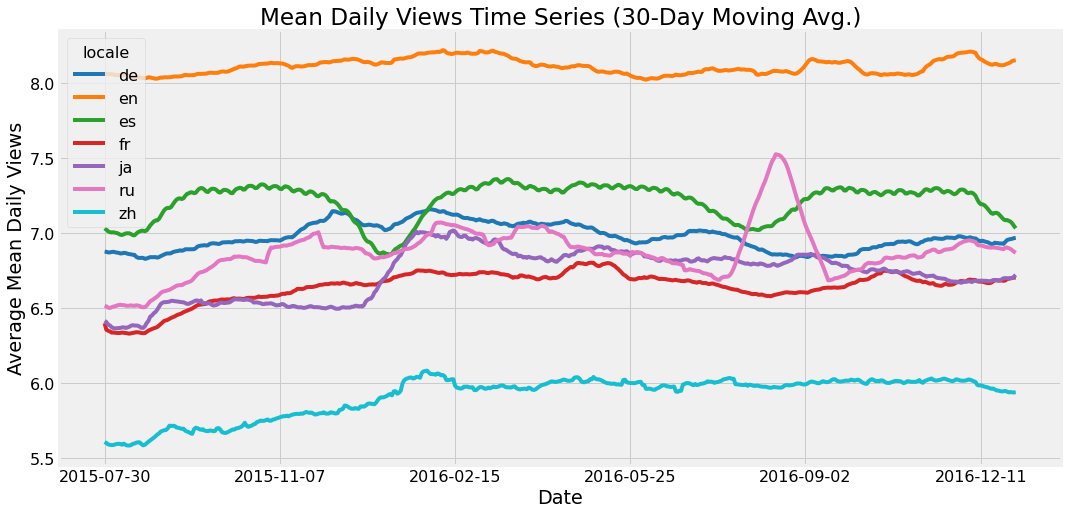

In [43]:
mean_locale.plot(figsize=(16,8), color=colors);
plt.xlabel('Date');
plt.ylabel('Average Mean Daily Views');
plt.title('Mean Daily Views Time Series (30-Day Moving Avg.)');

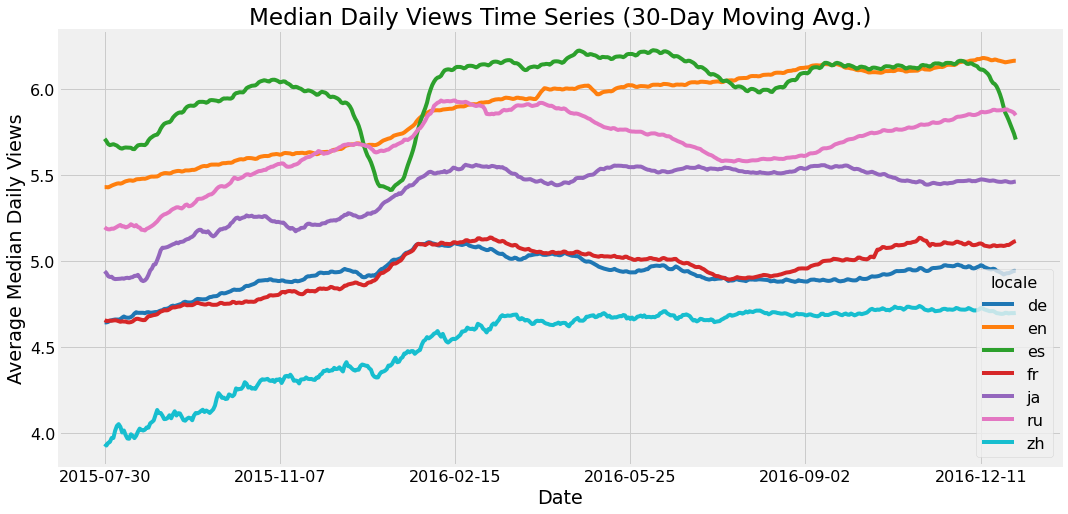

In [44]:
median_locale.plot(figsize=(16,8), color=colors);
plt.xlabel('Date');
plt.ylabel('Average Median Daily Views');
plt.title('Median Daily Views Time Series (30-Day Moving Avg.)');

From the graphs above, we see that English Wikipedia pages, by far, have the highest max daily views as well as mean daily views. In terms of median daily views, the locales are a little more even with English and Deutsch pages at a tie and all other locales not too far behind. Chinese pages rank lowest across the board. Also, there seems to be a slight downward trend in the max daily views across all locales as well as a slight positive trend in median daily views across all locales. 

<a id="section2d"></a>
## Average Daily Views Distributions

We will now look at the averages for views across all days for each article. Unsurprisingly, averaging the views across all days leads to highly skewed distributions. To fix this, we'll log transform the values. We'll stick to the random sample of 100,000 records for this analysis as well.

In [45]:
means = train_trunc.iloc[:,1:551].mean(axis=1).apply(np.log)
medians = train_trunc.iloc[:,1:551].median(axis=1).apply(np.log).apply(lambda x: 0 if x < 0 else x)
maxes = train_trunc.iloc[:,1:551].max(axis=1).apply(np.log)
stds = train_trunc.iloc[:,1:551].std(axis=1).apply(np.log)

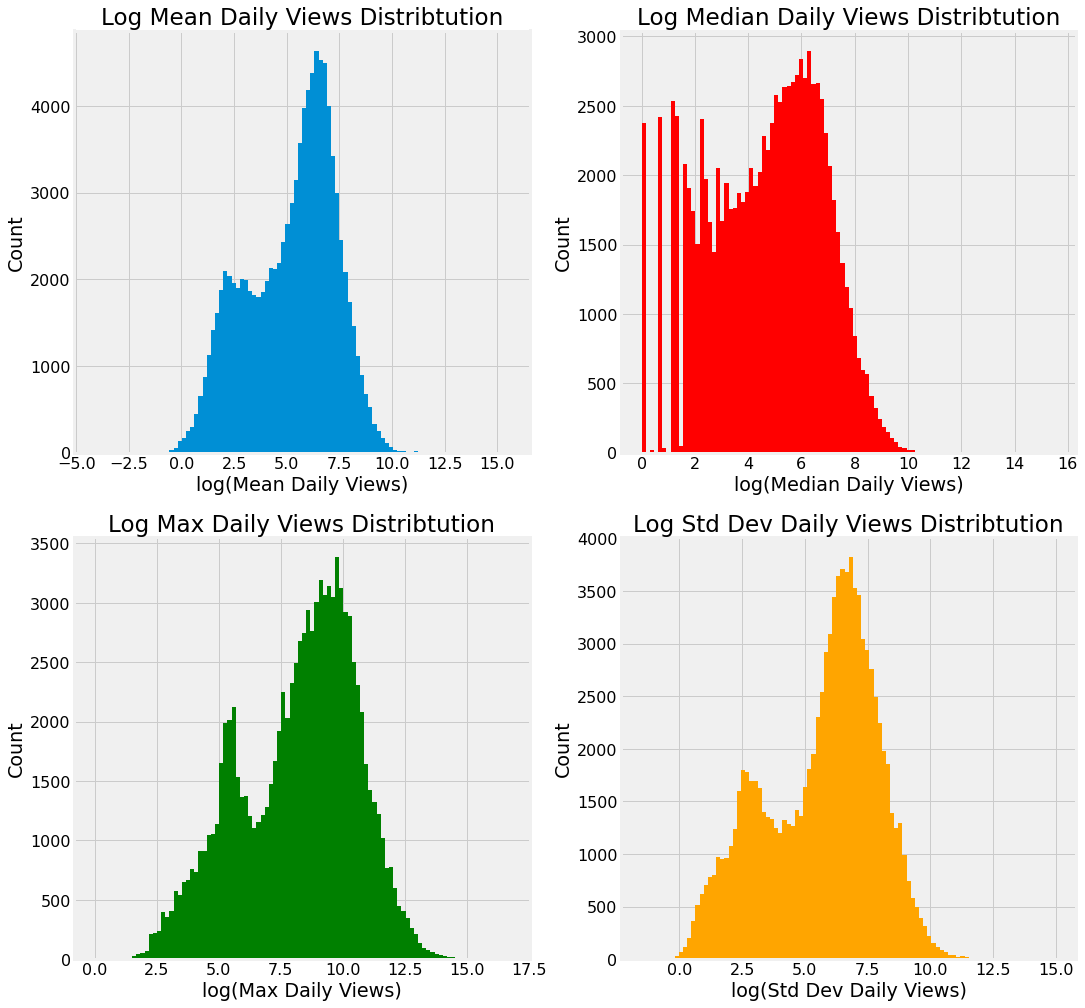

In [46]:
fig, ax = plt.subplots(2,2,figsize=(16,12));

plt.subplot(2,2,1);
plt.hist(means, bins=100);
plt.xlabel('log(Mean Daily Views)');
plt.ylabel('Count');
plt.title('Log Mean Daily Views Distribtution');

plt.subplot(2,2,2);
plt.hist(medians, bins=100, color='red');
plt.xlabel('log(Median Daily Views)');
plt.ylabel('Count');
plt.title('Log Median Daily Views Distribtution');

plt.subplot(2,2,3);
plt.hist(maxes, bins=100, color='green');
plt.xlabel('Date');
plt.xlabel('log(Max Daily Views)');
plt.ylabel('Count');
plt.title('Log Max Daily Views Distribtution');

plt.subplot(2,2,4);
plt.hist(stds, bins=100, color='orange');
plt.xlabel('log(Std Dev Daily Views)');
plt.ylabel('Count');
plt.title('Log Std Dev Daily Views Distribtution');

plt.subplots_adjust(top=1.2);

It is made evident that all of the metrics possess bimodal distributions, signaling separable groups of data points. 

<a id="section2e"></a>
## Average Daily Views Distributions (by Locale)

In [47]:
# Getting a random sample of 10,000 rows

random.seed(101)
train_trunc = train_df.loc[random.sample(list(train_df.index), 10000)].reset_index(drop = True)

In [48]:
mean_locale_dist = train_trunc.iloc[:,np.r_[1:551, -1]].set_index('locale').mean(axis=1).apply(np.log)
median_locale_dist = train_trunc.iloc[:,np.r_[1:551, -1]].set_index('locale').median(axis=1).apply(np.log).apply(lambda x: 0 if x < 0 else x)
max_locale_dist = train_trunc.iloc[:,np.r_[1:551, -1]].set_index('locale').max(axis=1).apply(np.log).apply(lambda x: 0 if x < 0 else x)
stds_locale_dist = train_trunc.iloc[:,np.r_[1:551, -1]].set_index('locale').std(axis=1).apply(np.log).apply(lambda x: 0 if x < 0 else x)

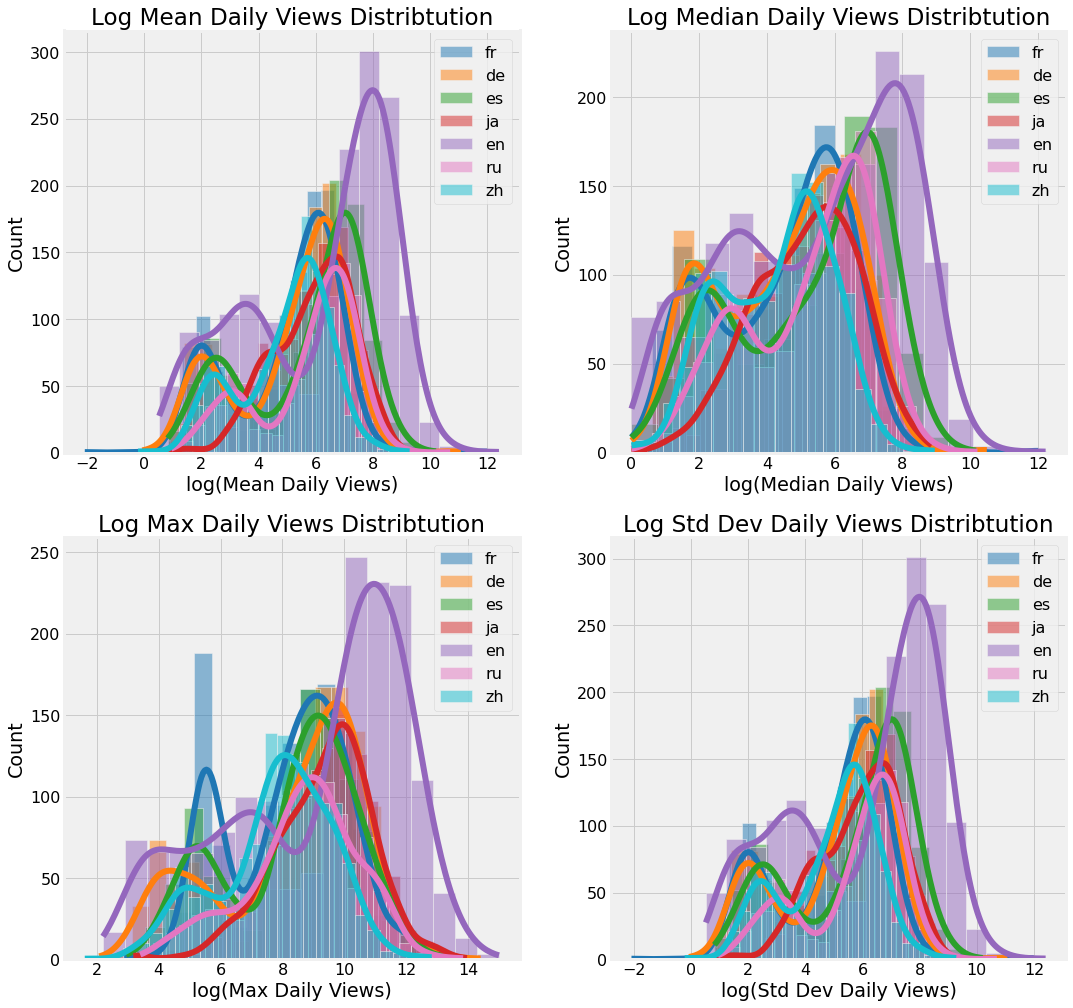

In [50]:
fig, ax = plt.subplots(2,2,figsize=(16,12));

labels = ['fr', 'de', 'es', 'ja', 'en', 'ru', 'zh']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple','tab:pink','tab:cyan']

plt.subplot(2,2,1);
for i in range(len(labels)):
    sns.histplot(list_of_lists(mean_locale_dist)[i], label=labels[i], color=colors[i], kde=True, line_kws=dict(linewidth=6));
plt.legend();
plt.xlabel('log(Mean Daily Views)');
plt.ylabel('Count');
plt.title('Log Mean Daily Views Distribtution');
plt.legend()

plt.subplot(2,2,2);
for i in range(len(labels)):
    sns.histplot(list_of_lists(median_locale_dist)[i], label=labels[i], kde=True, color=colors[i], line_kws=dict(linewidth=6));
plt.legend();
plt.xlabel('log(Median Daily Views)');
plt.ylabel('Count');
plt.title('Log Median Daily Views Distribtution');

plt.subplot(2,2,3);
for i in range(len(labels)):
    sns.histplot(list_of_lists(max_locale_dist)[i], label=labels[i], kde=True, color=colors[i], line_kws=dict(linewidth=6));
plt.legend();
plt.xlabel('Date');
plt.xlabel('log(Max Daily Views)');
plt.ylabel('Count');
plt.title('Log Max Daily Views Distribtution');

plt.subplot(2,2,4);
for i in range(len(labels)):
    sns.histplot(list_of_lists(mean_locale_dist)[i], label=labels[i], kde=True, color=colors[i], line_kws=dict(linewidth=6));
plt.legend();
plt.xlabel('log(Std Dev Daily Views)');
plt.ylabel('Count');
plt.title('Log Std Dev Daily Views Distribtution');

plt.subplots_adjust(top=1.2);

According to our plots, it looks like English Wikipedia pages are viewed the most, on average, having the largest mean/median/max daily views in comparison with the other languages. In contrast, the Russian pages are viewed the least along with the Chinese pages.

<a id="section2f"></a>
## Outlier Pages

Before we begin modeling, let's take a look at the web pages with the highest standard deviations. We will then use these pages when we build our models.

In [58]:
std_df = train_df.iloc[:,:551].set_index('Page').std(axis=1)

In [69]:
pd.DataFrame(std_df).reset_index().sort_values(0, ascending=False).head(10)

,Page,0
9774,Main_Page_en.wikipedia.org_desktop_all-agents,9.529194e+06
38573,Main_Page_en.wikipedia.org_all-access_all-agents,9.071410e+06
38574,Making_a_Murderer_en.wikipedia.org_all-access_...,8.916066e+06
74115,Making_a_Murderer_en.wikipedia.org_mobile-web_...,3.275409e+06
103123,Заглавная_страница_ru.wikipedia.org_desktop_al...,2.879428e+06
99322,Заглавная_страница_ru.wikipedia.org_all-access...,2.856762e+06
74114,Main_Page_en.wikipedia.org_mobile-web_all-agents,1.190981e+06
39180,Special:Search_en.wikipedia.org_all-access_all...,1.026681e+06
10403,Special:Search_en.wikipedia.org_desktop_all-ag...,9.548806e+05
33644,Main_Page_en.wikipedia.org_all-access_spider,8.324043e+05


In [163]:
mpaa = train_df[train_df.index == 38573].transpose().iloc[1:551,0].astype(float).apply(np.log)
mpma = train_df[train_df.index == 74114].transpose().iloc[1:551,0].astype(float).apply(np.log)
saa = train_df[train_df.index == 39180].transpose().iloc[1:551,0].astype(float).apply(np.log)
mpas = train_df[train_df.index == 33644].transpose().iloc[1:551,0].astype(float).apply(np.log)

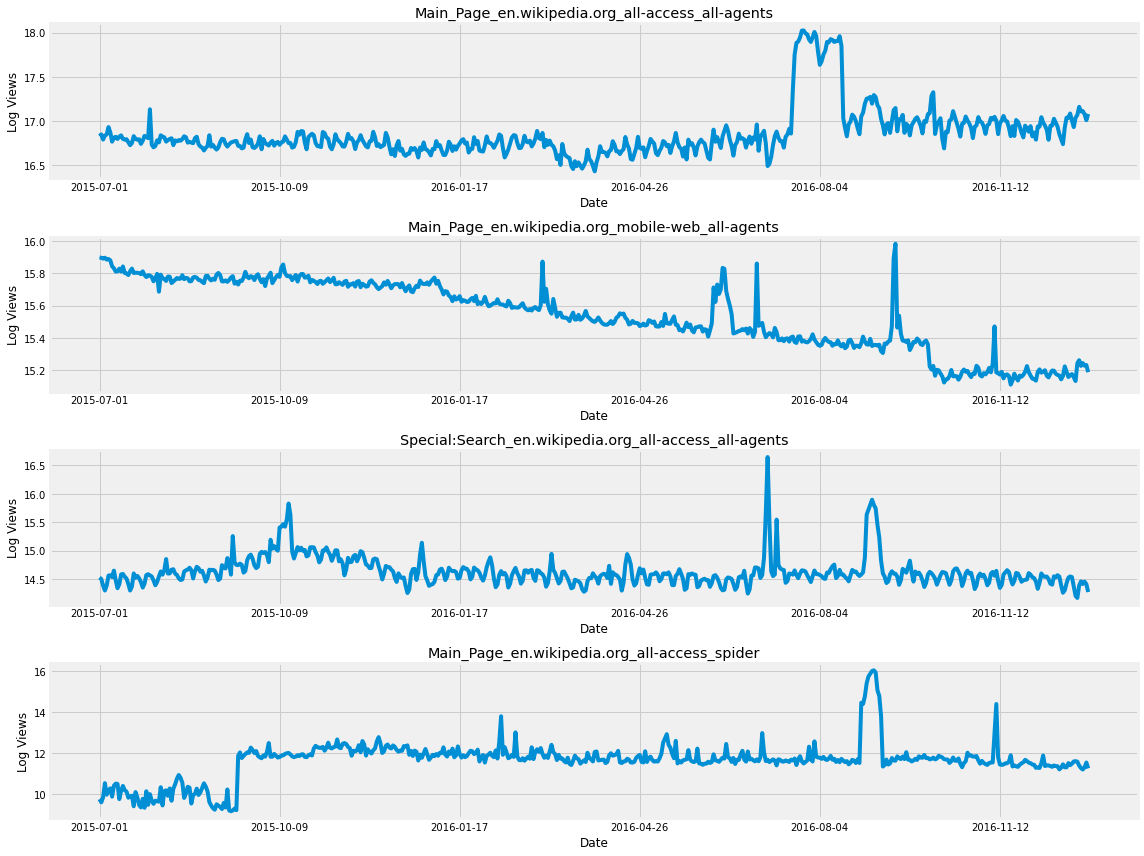

In [190]:
fig, ax = plt.subplots(4,1,figsize=(16,12));

plt.subplot(4,1,1);
mpaa.plot()
plt.xlabel('Date');
plt.ylabel('Log Views');
plt.title('Main_Page_en.wikipedia.org_all-access_all-agents');

plt.subplot(4,1,2);
mpma.plot()
plt.xlabel('Date');
plt.ylabel('Log Views');
plt.title('Main_Page_en.wikipedia.org_mobile-web_all-agents');

plt.subplot(4,1,3);
saa.plot()
plt.xlabel('Date');
plt.ylabel('Log Views');
plt.title('Special:Search_en.wikipedia.org_all-access_all-agents');

plt.subplot(4,1,4);
mpas.plot()
plt.xlabel('Date');
plt.ylabel('Log Views');
plt.title('Main_Page_en.wikipedia.org_all-access_spider');

fig.tight_layout() 
plt.show()

We've arbitrarily chosen 4 pages with some of the largest standard deviations. The idea is that if our models can accurately forecast the series of these outliers, then it will be well equipped to handle the forecasting of other pages with more stable view trends.

<a id="section3"></a>
# Modeling

<a id="section3a"></a>
## ARIMA

A popular approach in time series forecasting is to use an Autoregressive Integrated Moving Average (ARIMA) model. This kind of model consists of three parts, represented as the parameters 'p', 'd', and 'q':

**Auto-Regressive (p):** We are using past data to compute a regression model for future data. The parameter p indicates the range of lags.

**Integrated (d):** This is a differencing parameter, which gives us the number of times we are subtracting the current and the previous values of a time series. Differencing removes seasonal trends and gives the data a constant mean. 

**Moving Average (q):** This parameter gives us the number of previous error terms to include in the regression error of the model.

What we could do is use a ACF plot to check if our time series are stationary, and, if they are not, determine how many times the series would need to be differenced in order to become stationary. We could then take this number and use it as our 'd' value in the ARIMA model. Although, Python makes it easy to quickly loop through all possible p,d,q parameter values and select the model that produces the best fitting results. So, we will let Python do the heavy lifting for us.

In [457]:
mpaa_train, mpaa_test = train_test_split(mpaa)
mpma_train, mpma_test = train_test_split(mpma)
saa_train, saa_test = train_test_split(saa)
mpas_train, mpas_test = train_test_split(mpas)

In [300]:
mpaa_fit = arima_fit(mpaa_train)

The best model fit that was found: ((4, 0, 2), -998.0653994773772)


In [302]:
mpma_fit = arima_fit(mpma_train)

The best model fit that was found: ((4, 1, 4), -1552.2138291041372)


In [304]:
saa_fit = arima_fit(saa_train)

The best model fit that was found: ((3, 0, 4), -506.99767183169615)


In [306]:
mpas_fit = arima_fit(mpas_train)

The best model fit that was found: ((4, 1, 1), 399.2508692968464)


<a id="section3b"></a>
## ARIMA Forecasts

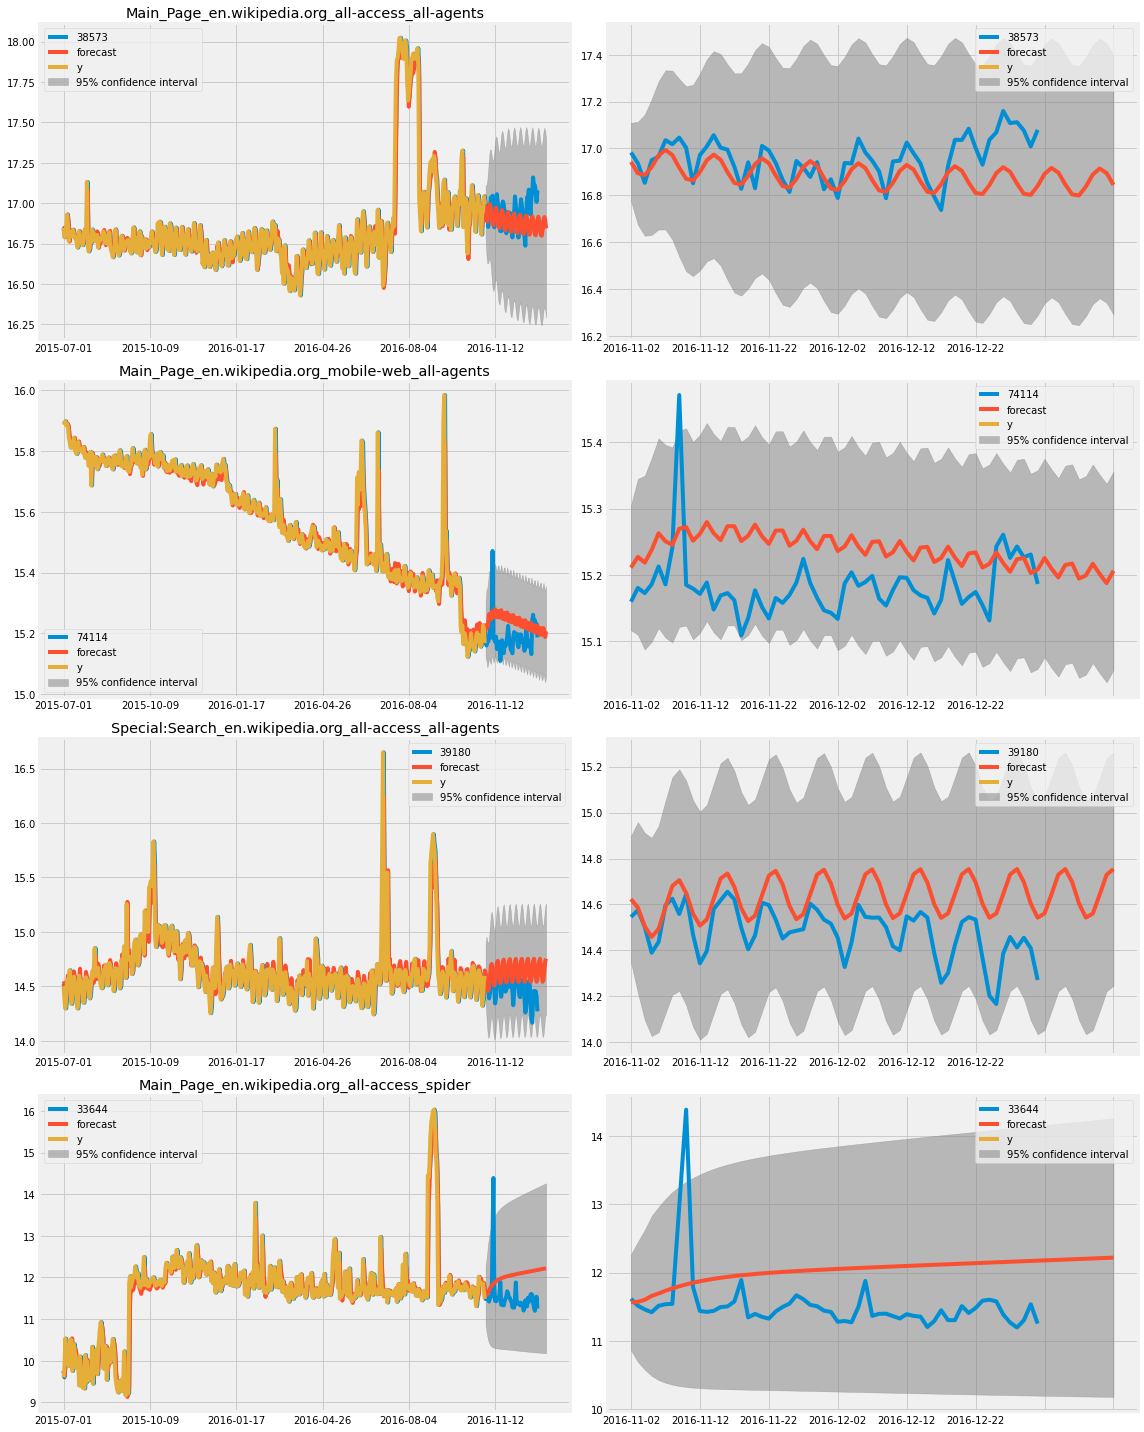

In [357]:
fig,ax = plt.subplots(4,2,figsize=(16,20), gridspec_kw={'width_ratios': [1,1]});

mpaa.plot(ax=ax[0][0]);
mpaa_fit.plot_predict(start=1, end=560, ax=ax[0][0]);
ax[0][0].title.set_text('Main_Page_en.wikipedia.org_all-access_all-agents')

mpaa[490:].plot(ax=ax[0][1]);
mpaa_fit.plot_predict(start=490, end=560, ax=ax[0][1]);


mpma.plot(ax=ax[1][0]);
mpma_fit.plot_predict(start=1, end=560, ax=ax[1][0]);
ax[1][0].title.set_text('Main_Page_en.wikipedia.org_mobile-web_all-agents')

mpma[490:].plot(ax=ax[1][1]);
mpma_fit.plot_predict(start=490, end=560, ax=ax[1][1]);


saa.plot(ax=ax[2][0]);
saa_fit.plot_predict(start=1, end=560, ax=ax[2][0]);
ax[2][0].title.set_text('Special:Search_en.wikipedia.org_all-access_all-agents')

saa[490:].plot(ax=ax[2][1]);
saa_fit.plot_predict(start=490, end=560, ax=ax[2][1]);


mpas.plot(ax=ax[3][0]);
mpas_fit.plot_predict(start=1, end=560, ax=ax[3][0]);
ax[3][0].title.set_text('Main_Page_en.wikipedia.org_all-access_spider')

mpas[490:].plot(ax=ax[3][1]);
mpas_fit.plot_predict(start=490, end=560, ax=ax[3][1]);

fig.tight_layout();
plt.show();

We see that the ARIMA models have done quite well! Almost all of the true daily view counts fall within the 95% confidence interval of the predictions produced by the model of each Wiki page. Now, let's use Facebook's Prophet and see how it's predictions stack up in comparison to our ARIMA models.

<a id="section3c"></a>
## Prophet

Prophet is an open-source time series forecasting library developed by Facebook. Prophet works as a Generalized Additive Model (GAM) which decomposes a time series into:

* A piecewise linear or logistic trend
* A yearly seasonal component
* A weekly seasonal component 
* An optional list of important days such as holidays and special events 

According to it's documentation, Prophet is *“robust to missing data, shifts in the trend, and large outliers”*, which would make it well suited for this particular task of forecasting time series' with large standard deviations and outliers.

In [505]:
fbp_1, forecast_1 = prophet_model(mpaa_train)
fbp_2, forecast_2 = prophet_model(mpma_train)
fbp_3, forecast_3 = prophet_model(saa_train)
fbp_4, forecast_4 = prophet_model(mpas_train)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [506]:
mpaa = mpaa.reset_index()
mpaa.columns = ['ds', 'y']
mpaa = mpaa.set_index('ds')
mpaa.index = pd.to_datetime(mpaa.index)

mpma = mpma.reset_index()
mpma.columns = ['ds', 'y']
mpma = mpma.set_index('ds')
mpma.index = pd.to_datetime(mpma.index)

saa = saa.reset_index()
saa.columns = ['ds', 'y']
saa = saa.set_index('ds')
saa.index = pd.to_datetime(saa.index)

mpas = mpas.reset_index()
mpas.columns = ['ds', 'y']
mpas = mpas.set_index('ds')
mpas.index = pd.to_datetime(mpas.index)

<a id="section3d"></a>
## Prophet Forecasts

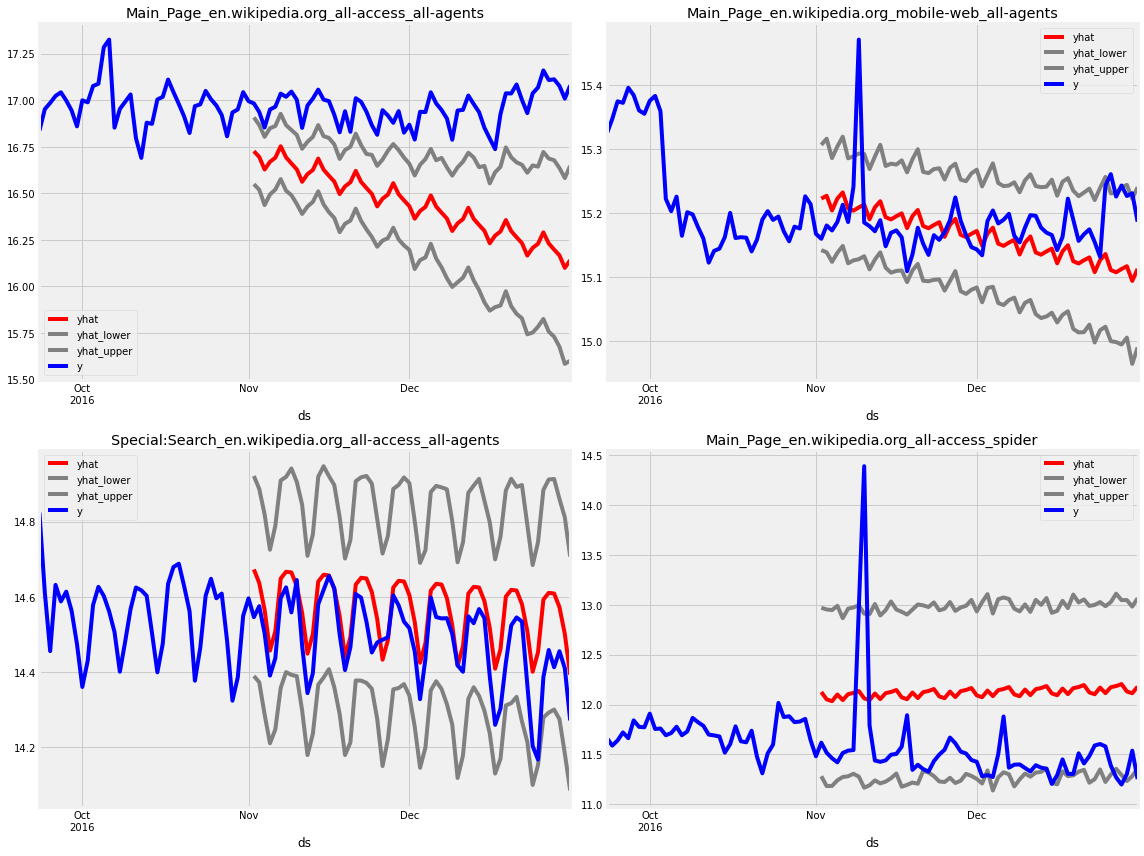

In [508]:
fig,ax = plt.subplots(2,2,figsize=(16,12));

forecast_1[490:].plot(ax=ax[0][0], color=['red','grey', 'grey']);
mpaa[-100:].plot(ax=ax[0][0], color='blue');
ax[0][0].title.set_text('Main_Page_en.wikipedia.org_all-access_all-agents')

forecast_2[490:].plot(ax=ax[0][1], color=['red','grey', 'grey']);
mpma[-100:].plot(ax=ax[0][1], color='blue');
ax[0][1].title.set_text('Main_Page_en.wikipedia.org_mobile-web_all-agents')

forecast_3[490:].plot(ax=ax[1][0], color=['red','grey', 'grey']);
saa[-100:].plot(ax=ax[1][0], color='blue');
ax[1][0].title.set_text('Special:Search_en.wikipedia.org_all-access_all-agents')

forecast_4[490:].plot(ax=ax[1][1], color=['red','grey', 'grey']);
mpas[-100:].plot(ax=ax[1][1], color='blue');
ax[1][1].title.set_text('Main_Page_en.wikipedia.org_all-access_spider')

fig.tight_layout();
plt.show();

It's clear that our Prophet models did not perform as well as our ARIMA models. For 'Main_Page_en.wikipedia.org_all-access_all-agents', Prophet fails to even capture the true values within it's confidence intervals. Also, Prophet predicts a declining trend for 'Main_Page_en.wikipedia.org_mobile-web_all-agents' when in fact it stays steady; nevertheless, most of the predictions stay within the confidence bounds. 

Facebook's Prophet, is noted as performing particularly well on datasets with multiple years of data available. We only have available to us about 1.5 years of data. Perhaps with more data, Prophet will perform better.